In [3]:
# combined_sentiment_nofunc.py
# Compact combined: Social Media outbreak + Drug review sentiment
!pip install pandas textblob wordcloud matplotlib scikit-learn

from textblob import TextBlob
from wordcloud import WordCloud
import pandas as pd, re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report



                                              0.0/624.3 kB ? eta -:--:--
     ------                                 102.4/624.3 kB 3.0 MB/s eta 0:00:01
     -----------------------------          481.3/624.3 kB 6.0 MB/s eta 0:00:01
     -------------------------------------- 624.3/624.3 kB 6.5 MB/s eta 0:00:00
                                              0.0/299.9 kB ? eta -:--:--
     -----------                             92.2/299.9 kB 5.1 MB/s eta 0:00:01
     -------------------------------------- 299.9/299.9 kB 6.2 MB/s eta 0:00:00
  Using cached nltk-3.9.2-py3-none-any.whl (1.5 MB)



[notice] A new release of pip is available: 23.1.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
# -------------------------
# social media (outbreak)
# -------------------------
posts = [
 "High fever and cough spreading in my area!",
 "So many people sick lately, hospitals are full.",
 "Feeling great today, no symptoms here.",
 "Severe cold and body ache since last week.",
 "No news of any infection in our town.",
 "Flu cases rising rapidly across the city!",
 "Just mild headache, nothing serious.",
 "Doctors report increase in respiratory illness.",
 "No sign of infection here, all safe!",
 "Many friends tested positive for flu recently."
]
locs = ['Mumbai','Delhi','Pune','Chennai','Goa','Delhi','Pune','Bangalore','Goa','Mumbai']


In [5]:
sm = pd.DataFrame({'text':posts,'loc':locs})

sm['clean'] = sm['text'].map(lambda s: re.sub(r'[^a-zA-Z\s]','',s).lower().strip())
sm['pol'] = sm['clean'].map(lambda s: TextBlob(s).sentiment.polarity)
kw_out = ['fever','cough','flu','infection','sick','ill','hospital','cold','headache','respiratory']
sm['kw'] = sm['clean'].map(lambda s: sum(w in s for w in kw_out))
sm['label'] = sm['pol'].map(lambda p: 1 if p < -0.1 else 0)  # negative sentiment => risk

print("\n-- Social Media sample --")
print(sm[['text','pol','kw','label']].head().to_string(index=False))




-- Social Media sample --
                                           text       pol  kw  label
     High fever and cough spreading in my area!  0.160000   2      0
So many people sick lately, hospitals are full. -0.041071   2      0
         Feeling great today, no symptoms here.  0.800000   0      0
     Severe cold and body ache since last week. -0.300000   1      1
          No news of any infection in our town.  0.000000   1      0


In [6]:
X = sm[['pol','kw']]; y = sm['label']
Xtr,Xte,ytr,yte = train_test_split(X,y,test_size=0.3,random_state=42)
m1 = LogisticRegression(max_iter=500).fit(Xtr,ytr)
pred = m1.predict(Xte)
print("\nSM Model Acc:", round(accuracy_score(yte,pred),3))
print(classification_report(yte,pred,zero_division=0))




SM Model Acc: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3

    accuracy                           1.00         3
   macro avg       1.00      1.00      1.00         3
weighted avg       1.00      1.00      1.00         3




Outbreak risk by location:
 loc
Chennai      1.0
Bangalore    0.0
Delhi        0.0
Goa          0.0
Mumbai       0.0
Pune         0.0


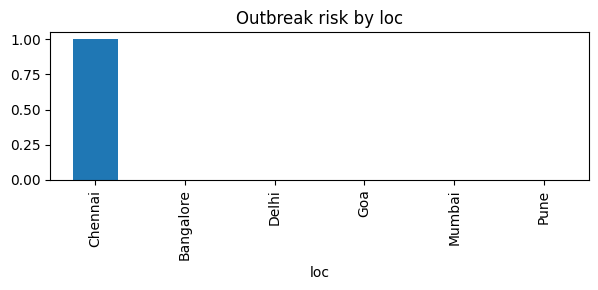

In [7]:
risk = sm.groupby('loc')['label'].mean().sort_values(ascending=False)
print("\nOutbreak risk by location:\n", risk.to_string())

plt.figure(figsize=(6,3)); risk.plot(kind='bar'); plt.title('Outbreak risk by loc'); plt.tight_layout(); plt.show()



In [8]:
# -------------------------
# drug reviews
# -------------------------
data = {
 'review': [
  "This medicine worked great for my headache, quick relief!",
  "Terrible side effects, I felt dizzy and nauseous.",
  "It helped reduce my fever in just one day.",
  "Did not work at all, complete waste of money.",
  "Mild improvement, but caused stomach pain.",
  "Highly effective for pain relief, totally recommend it!",
  "Too expensive for such little effect.",
  "Very satisfied with the results, no side effects.",
  "I had allergic reactions after taking this pill.",
  "Works okay, but takes too long to show effect."
 ],
 'drug_name': ["PainAway","PainAway","FeverGo","FeverGo","CurePlus","PainAway","CurePlus","FeverGo","CurePlus","PainAway"]
}
dr = pd.DataFrame(data)

dr['clean'] = dr['review'].map(lambda s: re.sub(r'[^a-zA-Z\s]','',s).lower().strip())
dr['pol'] = dr['clean'].map(lambda s: TextBlob(s).sentiment.polarity)
dr['label'] = dr['pol'].map(lambda p: 'Positive' if p > 0 else 'Negative')

print("\n-- Drug reviews sample --")
print(dr[['review','pol','label']].head().to_string(index=False))




-- Drug reviews sample --
                                                   review       pol    label
This medicine worked great for my headache, quick relief!  0.566667 Positive
        Terrible side effects, I felt dizzy and nauseous. -1.000000 Negative
               It helped reduce my fever in just one day.  0.000000 Negative
            Did not work at all, complete waste of money. -0.050000 Negative
               Mild improvement, but caused stomach pain.  0.333333 Positive


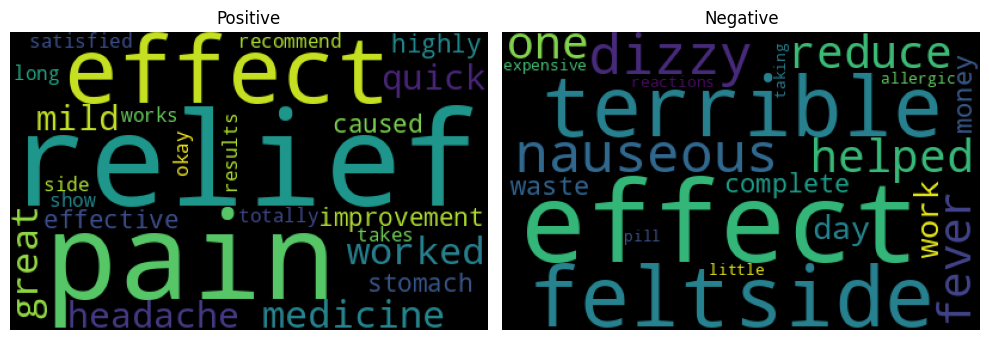

In [9]:
# wordclouds
pos_text = " ".join(dr[dr['label']=='Positive']['clean'])
neg_text = " ".join(dr[dr['label']=='Negative']['clean'])
plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.imshow(WordCloud(width=400,height=250).generate(pos_text)); plt.axis('off'); plt.title('Positive')
plt.subplot(1,2,2); plt.imshow(WordCloud(width=400,height=250).generate(neg_text)); plt.axis('off'); plt.title('Negative')
plt.tight_layout(); plt.show()



In [10]:
# keyword score & model
pos_kw = ['good','great','effective','recommend','relief']
neg_kw = ['bad','terrible','waste','pain','dizzy','allergic']
dr['kw'] = dr['clean'].map(lambda s: sum(w in s for w in pos_kw) - sum(w in s for w in neg_kw))

X = dr[['pol','kw']]; y = dr['label'].map({'Positive':1,'Negative':0})
Xtr,Xte,ytr,yte = train_test_split(X,y,test_size=0.3,random_state=42)
m2 = LogisticRegression(max_iter=500).fit(Xtr,ytr)
pred = m2.predict(Xte)
print("\nDrug Model Acc:", round(accuracy_score(yte,pred),3))
print(classification_report(yte,pred,target_names=['Negative','Positive'], zero_division=0))




Drug Model Acc: 1.0
              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00         2
    Positive       1.00      1.00      1.00         1

    accuracy                           1.00         3
   macro avg       1.00      1.00      1.00         3
weighted avg       1.00      1.00      1.00         3




Avg sentiment by drug:
    Drug   AvgPol
CurePlus 0.034722
 FeverGo 0.200000
PainAway 0.022917


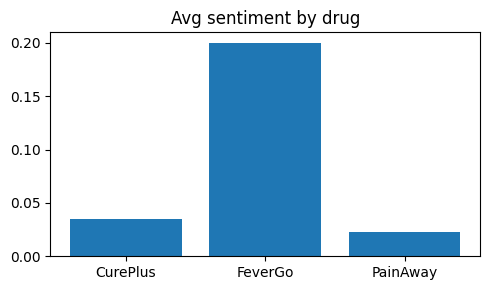

In [11]:
# drug-wise avg sentiment
ds = dr.groupby('drug_name')['pol'].mean().reset_index().rename(columns={'drug_name':'Drug','pol':'AvgPol'})
print("\nAvg sentiment by drug:")
print(ds.to_string(index=False))
plt.figure(figsize=(5,3)); plt.bar(ds['Drug'], ds['AvgPol']); plt.title('Avg sentiment by drug'); plt.tight_layout(); plt.show()

# -------------------------
# done
# -------------------------
